In [13]:
import tensorflow as tf
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline
import threading
import tensorflow.contrib.slim as slim
from utils import data_utils, train_utils
import datetime
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def argument_scope(H, phase):
    '''
    This returns the arg_scope for slim.arg_scope(), which defines the options for slim.functions
    '''
    padding = H['padding']
    is_training = {'train': True, 'validate': False, 'test': False}[phase]
    pool_kernel = [2, 2]
    pool_stride = 2

    
    params = {
        "decay": 0.997,
        "epsilon": 0.001,
    }

    with slim.arg_scope([slim.conv2d], 
                        # slim.relu would raise an error here
                        activation_fn=tf.nn.relu, 
                        padding=padding, 
                        normalizer_fn=slim.batch_norm, 
                        # normalizer_fn=None,
                        weights_initializer=tf.contrib.layers.variance_scaling_initializer()):
        with slim.arg_scope([slim.batch_norm, slim.dropout], is_training=is_training):
            with slim.arg_scope([slim.max_pool2d], stride=pool_stride, kernel_size=pool_kernel):
                with slim.arg_scope([slim.conv2d_transpose], 
                                    activation_fn=None, 
                                    normalizer_fn=None,
                                    padding=padding, 
                                    weights_initializer=tf.contrib.layers.variance_scaling_initializer()) as sc:
                    return sc

In [3]:
def build_pred(x_in, H, phase):
    '''
    This function builds the prediction model
    '''
    num_class = H['num_class']
    
    conv_kernel_1 = [1, 1]
    conv_kernel_3 = [3, 3]
    pool_kernel = [2, 2]
    pool_stride = 2

    early_feature = {}
    reuse = {'train': False, 'validate': True, 'test': False}[phase]
    
    with slim.arg_scope(argument_scope(H, phase)):
        
        scope_name = 'block_1'
        x_input = x_in
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_2'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_3'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_4'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_5'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 1024
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_6'
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_4'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_7'
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_3'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_8'
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_2'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_9'
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_1'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'pred'
        with tf.variable_scope(scope_name, reuse = reuse):
            # layer_1 = slim.conv2d(layer_2, num_class, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)
            layer_1 = slim.conv2d(layer_2, 1, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)

            early_feature[scope_name] = layer_1
            
            # pred = tf.argmax(tf.nn.softmax(logits=layer_1), axis=3)
            pred = tf.sigmoid(layer_1)
                
        return tf.squeeze(layer_1), tf.squeeze(pred)

In [4]:
hypes = './hypes/hypes.json'
with open(hypes, 'r') as f:
    H = simplejson.load(f)

In [5]:
img_in = tf.placeholder(dtype=tf.float32, shape=[1, 3200, 3200, 16])

In [6]:
logits, pred = build_pred(img_in, H, 'test')

In [7]:
img_data = data_utils.ImageData(17)
img_data.load_image()
img_data.create_label()
img_data.create_train_feature()

In [36]:
config = tf.ConfigProto(device_count = {'GPU': 0})
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path='log_dir/8-11_15-12/ckpt/ckpt-3001')
    predictions, = sess.run([pred], 
                           feed_dict = {img_in: np.reshape(img_data.train_feature[:3200, :3200, :], 
                                                           [1, 3200, 3200, 16])})

INFO:tensorflow:Restoring parameters from log_dir/8-11_15-12/ckpt/ckpt-3001


In [37]:
img_data.train_feature.shape

(3348, 3403, 16)

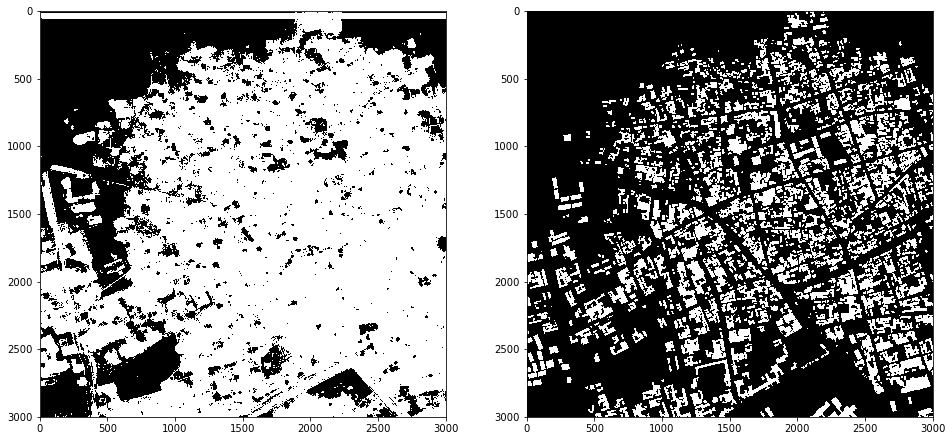

In [38]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.5).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [34]:
np.mean(predictions), np.std(predictions)

(1.0, 1.3259792e-06)

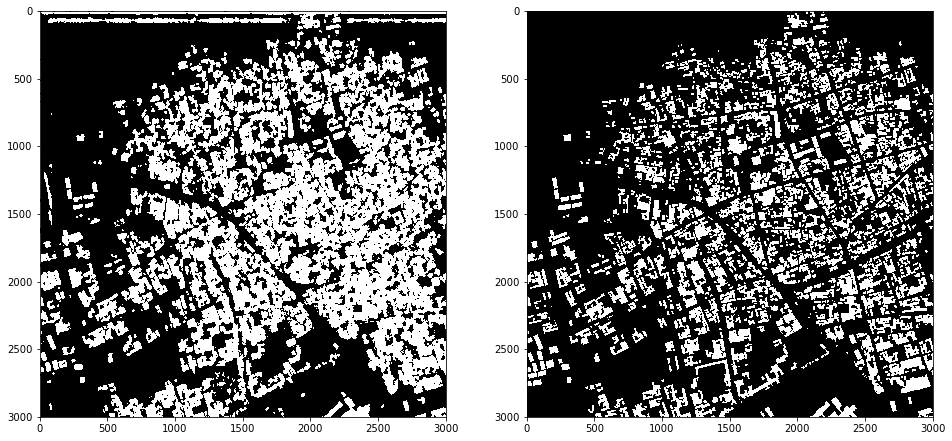

In [12]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.8).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

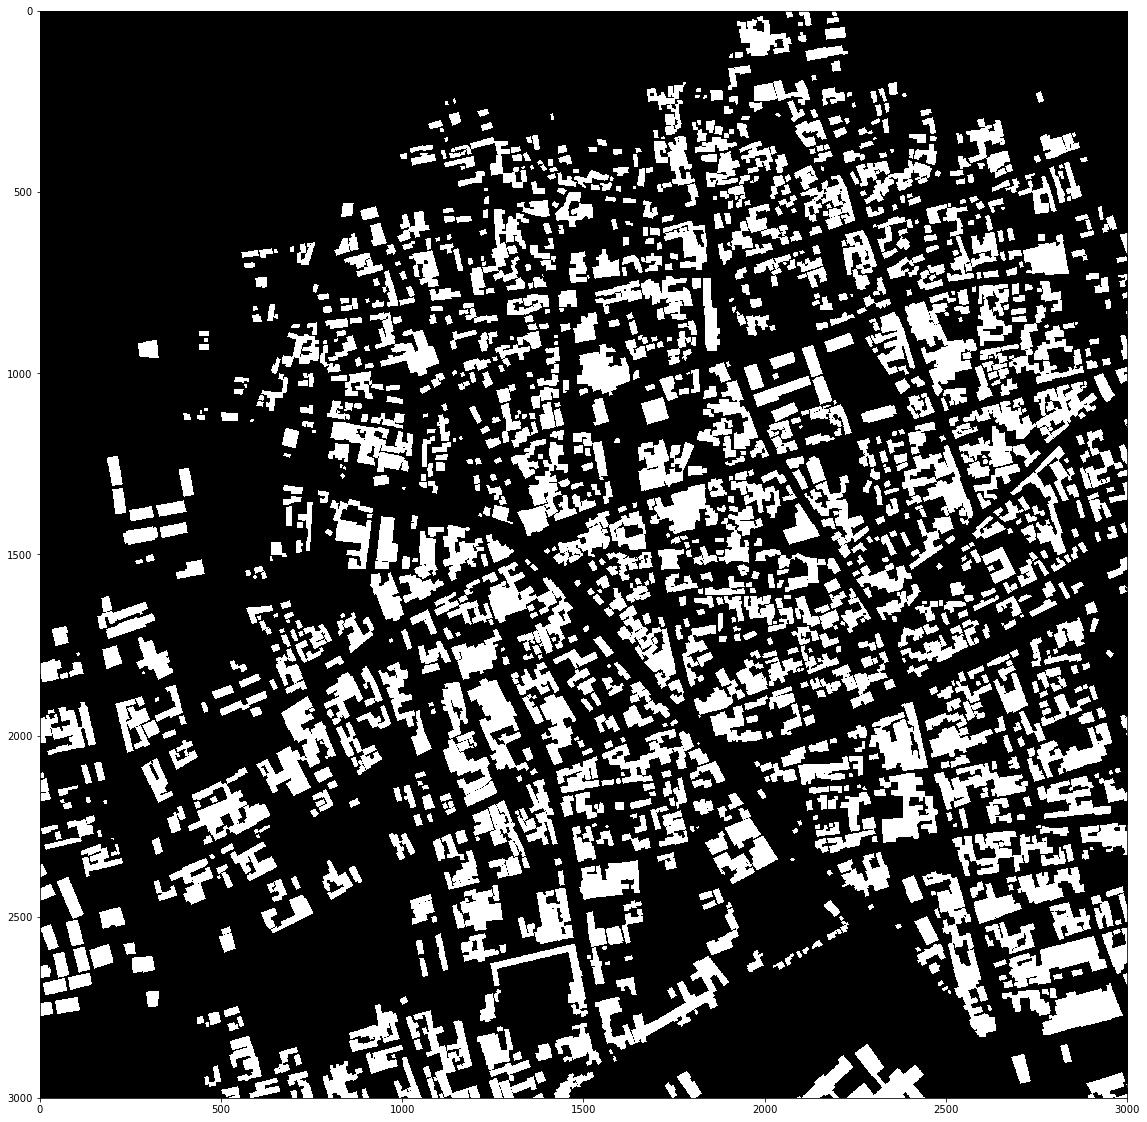

In [64]:
fig, axs = plt.subplots(figsize = [20, 20])
axs.imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [46]:
np.mean(predictions), np.std(predictions)

(0.2530494, 0.38191122)

In [61]:
data_utils.image_IDs_dict

{0: '6010_1_2',
 1: '6010_4_2',
 2: '6010_4_4',
 3: '6040_1_0',
 4: '6040_1_3',
 5: '6040_2_2',
 6: '6040_4_4',
 7: '6060_2_3',
 8: '6070_2_3',
 9: '6090_2_0',
 10: '6100_1_3',
 11: '6100_2_2',
 12: '6100_2_3',
 13: '6110_1_2',
 14: '6110_3_1',
 15: '6110_4_0',
 16: '6120_2_0',
 17: '6120_2_2',
 18: '6140_1_2',
 19: '6140_3_1',
 20: '6150_2_3',
 21: '6160_2_1',
 22: '6170_0_4',
 23: '6170_2_4',
 24: '6170_4_1'}

In [37]:
predictions

array([[ 0.65830004,  0.77082956,  0.31433627, ...,  0.11276927,
         0.06869517,  0.93646824],
       [ 0.98857504,  0.99910331,  0.99984145, ...,  0.98267984,
         0.99953127,  0.99488127],
       [ 0.90955269,  0.9965378 ,  0.97428995, ...,  0.01336849,
         0.99189103,  0.63985705],
       ..., 
       [ 0.99962175,  0.99999642,  0.99997842, ...,  0.99999964,
         0.99998808,  0.9999783 ],
       [ 0.99946851,  1.        ,  1.        , ...,  1.        ,
         1.        ,  0.99939811],
       [ 0.96523243,  0.99992478,  0.99986517, ...,  0.99435991,
         0.99993563,  0.45286894]], dtype=float32)

In [35]:
predictions[:20,:20]

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.99999988,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  